In [1]:
%reload_ext autoreload
%autoreload 2

import os, sys
if os.environ['USER'] == 'yitians' and 'submit' in os.uname().nodename:
    os.environ['DM21CM_DATA_DIR'] = '/data/submit/yitians/dm21cm/DM21cm'
    os.environ['DH_DIR'] = '/work/submit/yitians/darkhistory/DarkHistory'
sys.path.append('..')
sys.path.append(os.environ['DH_DIR'])

from tqdm import tqdm
import time

import numpy as np
import jax.numpy as jnp

import py21cmfast as p21c
from py21cmfast import plotting, cache_tools
print(f'Using 21cmFAST version {p21c.__version__}')

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
mpl.rc_file('../matplotlibrc')

/work/submit/yitians/anaconda3/envs/21cmfast/lib/python3.7/site-packages/py21cmfast/_cfg.py:59: UserWarning: Your configuration file is out of date. Updating...
  "Your configuration file is out of date. Updating..."
/work/submit/yitians/anaconda3/envs/21cmfast/lib/python3.7/site-packages/py21cmfast/_cfg.py:42: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn("Your configuration file is out of date. Updating...")


Using 21cmFAST version 0.1.dev1578+g6f96f89.d20230224


In [2]:
import logging
logger = logging.getLogger('21cmFAST')
logger.setLevel(logging.INFO)
logging.getLogger('py21cmfast._utils').setLevel(logging.CRITICAL+1)
logging.getLogger('py21cmfast.wrapper').setLevel(logging.CRITICAL+1)

In [14]:
from dm21cm.injection import DMParams
from dm21cm.common import abscs_nBs_test_2 as abscs
from dm21cm.data_loader import load_data
import dm21cm.physics as phys

In [4]:
from darkhistory.spec.spectrum import Spectrum

## 0. Global config

In [5]:
! lscpu | grep "CPU(s)"

CPU(s):                48
On-line CPU(s) list:   0-47
NUMA node0 CPU(s):     0,2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34,36,38,40,42,44,46
NUMA node1 CPU(s):     1,3,5,7,9,11,13,15,17,19,21,23,25,27,29,31,33,35,37,39,41,43,45,47


In [6]:
N_THREADS = 32

In [7]:
def get_z_arr(z_start=None, z_end=20):
    
    if z_start is None:
        z_start = p21c.global_params.Z_HEAT_MAX
    z_arr = [z_end]
    while np.max(z_arr) < z_start:
        z_prev = (1 + np.max(z_arr)) * p21c.global_params.ZPRIME_STEP_FACTOR - 1
        z_arr.append(z_prev)
    return np.array(z_arr[::-1][1:])

In [8]:
# check cached runs
CACHE_DIR_BASE = '/scratch/submit/ctp/yitians/21cmFAST-cache'
os.listdir(CACHE_DIR_BASE)

['test',
 'emf_comp_spf_mh3',
 'emf_comp_dh_mh3',
 'emf_comp_dh_mh6',
 'emf_comp_dh_mh9',
 'emf_comp_base']

## 1. Initialization

In [81]:
# config
RUN_NAME = 'testdhph'
f_scheme = 'DH'
struct_boost_model = 'erfc 1e-3'
run_mode = 'inj'

p21c.config['direc'] = f'{CACHE_DIR_BASE}/{RUN_NAME}'
os.makedirs(p21c.config['direc'], exist_ok=True)

In [82]:
cache_tools.clear_cache()

2023-03-19 04:01:49,473 | INFO | Removed 0 files from cache.
INFO:21cmFAST:Removed 0 files from cache.


## 2. Loop

In [72]:
from main import evolve

In [ ]:
# redshift
p21c.global_params.ZPRIME_STEP_FACTOR = 1.05
p21c.global_params.Z_HEAT_MAX = 44.
z_arr = get_z_arr(z_end=6.)

# dark matter
dm_params = DMParams(mode='swave', primary='mu', m_DM=1e10, sigmav=1e-26)

soln = evolve(DM_process=dm_params.mode, mDM=dm_params.m_DM,
       sigmav=dm_params.sigmav, primary=dm_params.primary,
       struct_boost=phys.struct_boost_func(model=struct_boost_model),
       start_rs=3000, end_rs=z_arr[0], coarsen_factor=12, verbose=1)

In [80]:
soln['highengphot'][-1]

In [83]:
# physics
cosmo_params_EMF = dict(OMm=0.32, OMb=0.049, POWER_INDEX=0.96, SIGMA_8=0.83, hlittle=0.67)

initial_conditions = p21c.initial_conditions(
    user_params = p21c.UserParams(
        HII_DIM = 50, # [1]
        BOX_LEN = 50, # [p-Mpc]
        N_THREADS = N_THREADS
    ),
    cosmo_params = p21c.CosmoParams(**cosmo_params_EMF),
    random_seed=54321, write=True
)

# tmp switches
reload = False
propagate_photon = True

# box
box_dim = initial_conditions.user_params.HII_DIM
n_pix = box_dim ** 3
box_shape = (box_dim, box_dim, box_dim)

# recording
records = []
i_slice = int(box_dim/2)
input_time_tot = 0.
p21c_time_tot = 0.

## LOOP
for i_z in tqdm(range(len(z_arr))):

    z = z_arr[i_z]
    
    input_timer = time.time()
    
    if i_z == 0:
        spin_temp = None
        input_heating = input_ionization = input_jalpha = None
        
        ## load tfs
        phot_phot_tf = load_data('phot_phot', reload=reload)
        elec_phot_tf = load_data('elec_phot', reload=reload)
        phot_dep_tf = load_data('phot_dep', reload=reload)
        elec_dep_tf = load_data('elec_dep', reload=reload)
        
        ## fix DM in spec
        phot_phot_tf.set_fixed_in_spec(dm_params.inj_phot_spec.N)
        elec_phot_tf.set_fixed_in_spec(dm_params.inj_elec_spec.N)
        phot_dep_tf.set_fixed_in_spec(dm_params.inj_phot_spec.N)
        elec_dep_tf.set_fixed_in_spec(dm_params.inj_elec_spec.N)
        
        # photon bath
        phot_bath = Spectrum(
            abscs['photE'], np.zeros_like(abscs['photE']), spec_type='N', rs=1+z_arr[0]
        ) # [N per Bavg]
        phot_bath = soln['highengphot'][-1]
        phot_bath_next = phot_bath * 0
    
    else: ## input from second step
        
        input_heating = p21c.input_heating(redshift=z, init_boxes=initial_conditions, write=False)
        input_ionization = p21c.input_ionization(redshift=z, init_boxes=initial_conditions, write=False)
        input_jalpha = p21c.input_jalpha(redshift=z, init_boxes=initial_conditions, write=False)

        if run_mode == '':
            if i_z == 1:
                logger.warning('Not injecting anything in this run!')

        elif run_mode == 'inj':
            
            ## common
            delta_box = jnp.asarray(perturbed_field.density)
            x_e_box = jnp.asarray(1 - ionized_box.xH_box)
            
            ## photon bath: from previous step
            if propagate_photon:
                phot_bath_next.redshift(1+z)
                phot_bath = phot_bath_next
            
            ## photon bath -> photon
            out_phot_N = phot_phot_tf(
                rs = 1 + z,
                in_spec = phot_bath.N,
                nBs_s = delta_box.ravel(),
                x_s = x_e_box.ravel(),
                sum_result = True,
                out_of_bounds_action = 'clip',
            ) / (box_dim ** 3)

            phot_bath_next = Spectrum(
                phot_phot_tf.abscs['out'],
                out_phot_N,
                spec_type='N', rs=1+z
            ) # [N / Bavg]
            
            ## photon bath -> deposition
            phot_bath_dep_box = phot_dep_tf(
                rs = 1 + z,
                in_spec = phot_bath.N,
                nBs_s = delta_box.ravel(),
                x_s = x_e_box.ravel(),
                sum_result = False,
                out_of_bounds_action = 'clip',
            ).reshape(box_dim, box_dim, box_dim, len(abscs['dep_c'])) # [eV / Bavg]
            
            ## DM: common
            z_prev = z_arr[i_z-1]
            dt = phys.dt_between_z(z_prev, z)
            
            rho_DM_box = (1 + delta_box) * phys.rho_DM * (1+z)**3 # [eV cm^-3]
            n_Bavg = phys.n_B * (1+z)**3 # [Bavg cm^-3]
            inj_per_Bavg_box = phys.inj_rate(rho_DM_box, dm_params) * dt * struct_boost / n_Bavg # [inj/Bavg]
            
            if dm_params.mode == 'swave':
                struct_boost = phys.struct_boost_func(model=struct_boost_model)(1+z)
            else:
                struct_boost = 1
            
            ## DM -> photon
            out_phot_N_phot = phot_phot_tf(
                rs = 1 + z,
                in_spec = dm_params.inj_phot_spec.N,
                nBs_s = delta_box.ravel(),
                x_s = x_e_box.ravel(),
                sum_result = True,
                sum_weight = inj_per_Bavg_box.ravel(),
                out_of_bounds_action = 'clip',
            ) / (box_dim ** 3) # [N / Bavg]

            out_phot_N_elec = elec_phot_tf(
                rs = 1 + z,
                in_spec = dm_params.inj_elec_spec.N,
                nBs_s = delta_box.ravel(),
                x_s = x_e_box.ravel(),
                sum_result = True,
                sum_weight = inj_per_Bavg_box.ravel(),
                out_of_bounds_action = 'clip',
            ) / (box_dim ** 3) # [N / Bavg]

            phot_bath_next += Spectrum(
                phot_phot_tf.abscs['out'],
                out_phot_N_phot + out_phot_N_elec,
                spec_type='N', rs=1+z
            )
            
            ## DM -> deposition
            DM_phot_dep_box = phot_dep_tf(
                rs = 1 + z,
                in_spec = dm_params.inj_phot_spec.N,
                nBs_s = delta_box.ravel(),
                x_s = x_e_box.ravel(),
                sum_result = False,
                out_of_bounds_action = 'clip',
            ).reshape(box_dim, box_dim, box_dim, len(abscs['dep_c'])) * inj_per_Bavg_box[...,None] # [eV / Bavg]

            DM_elec_dep_box = elec_dep_tf(
                rs = 1 + z,
                in_spec = dm_params.inj_elec_spec.N,
                nBs_s = delta_box.ravel(),
                x_s = x_e_box.ravel(),
                sum_result = False,
                out_of_bounds_action = 'clip',
            ).reshape(box_dim, box_dim, box_dim, len(abscs['dep_c'])) * inj_per_Bavg_box[...,None] # [eV / Bavg]
            
            ## deposite energy
            dep_box = phot_bath_dep_box + DM_phot_dep_box + DM_elec_dep_box # [eV / Bavg]
            # last dimension: ('H ion', 'He ion', 'exc', 'heat', 'cont')

            input_heating.input_heating += np.array(2 / (3*phys.kB*(1+x_e_box)) * dep_box[...,3]) # [K]
            input_ionization.input_ionization += np.array(dep_box[...,0] + dep_box[...,1]) / phys.rydberg # [1/Bavg]
            
            n_lya = dep_box[...,2] / phys.lya_eng # [lya photon # cm^-3]
            dnu_lya = (phys.rydberg - phys.lya_eng) / (2*np.pi*phys.hbar) # [Hz^-1]
            J_lya = n_lya * phys.c / (4*np.pi) / dnu_lya # [lya photon # cm^-2 s^-1 sr^-1 Hz^-1]
            input_jalpha.input_jalpha += np.array(J_lya)
            
        else:
            raise ValueError(run_mode)
            
    input_time_tot += time.time() - input_timer

    ## step in 21cmFAST
    p21c_timer = time.time()
    perturbed_field = p21c.perturb_field( # perturbed_field controls the redshift
        redshift=z,
        init_boxes=initial_conditions
    )
    spin_temp = p21c.spin_temperature(
        perturbed_field=perturbed_field,
        previous_spin_temp=spin_temp,
        input_heating_box=input_heating,
        input_ionization_box=input_ionization,
        input_jalpha_box=input_jalpha,
        write=True
    )
    ionized_box = p21c.ionize_box(
        spin_temp=spin_temp
    )
    brightness_temp = p21c.brightness_temperature(
        ionized_box=ionized_box,
        perturbed_field=perturbed_field,
        spin_temp=spin_temp
    )
    p21c_time_tot += time.time() - p21c_timer

    ## save results
    if i_z > 0:
        record = {
            'z'   : z,
            'T_s' : np.mean(spin_temp.Ts_box), # [mK]
            'T_b' : np.mean(brightness_temp.brightness_temp), # [K]
            'T_k' : np.mean(spin_temp.Tk_box), # [K]
            'x_e' : np.mean(1 - ionized_box.xH_box), # [1]
        }
        # if run_mode == 'inj':
        #     record_inj = {
        #         'dE_inj_per_B' : input_boxs['dE_inj_per_B_mean'], # [eV per B]
        #         'f_heat' : input_boxs['f_heat_mean'],
        #         'f_ion'  : input_boxs['f_ion_mean'],
        #         'f_exc'  : input_boxs['f_exc_mean'],
        #     }
        #     record.update(record_inj)
        records.append(record)
    
print(f'input used {input_time_tot:.4f} s')
print(f'p21c used {p21c_time_tot:.4f} s')

/work/submit/yitians/anaconda3/envs/21cmfast/lib/python3.7/site-packages/py21cmfast/inputs.py:488: UserWarning: The USE_INTERPOLATION_TABLES setting has changed in v3.1.2 to be default True. You can likely ignore this warning, but if you relied onhaving USE_INTERPOLATION_TABLES=False by *default*, please set it explicitly. To silence this warning, set it explicitly to True. Thiswarning will be removed in v4.
  "The USE_INTERPOLATION_TABLES setting has changed in v3.1.2 to be "

100%|██████████| 39/39 [04:49<00:00,  7.42s/it]

input used 157.4750 s
p21c used 131.8085 s


In [84]:
arr_records = {k: np.array([r[k] for r in records]) for k in records[0].keys()}
np.save(f'../data/run_info/{RUN_NAME}_records', arr_records)

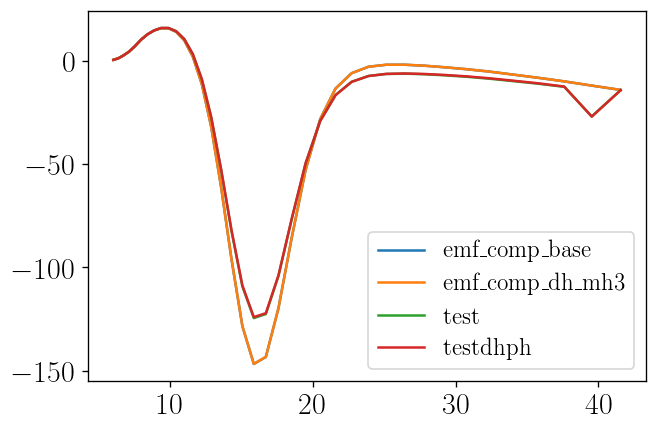

In [85]:
fig, ax = plt.subplots(figsize=(6,4))

for name in ['emf_comp_base', 'emf_comp_dh_mh3', 'test', 'testdhph']:
    
    records = np.load(f'../data/run_info/{name}_records.npy', allow_pickle=True).item()
    ax.plot(records['z'], records['T_b'], label=name)
ax.legend()

In [ ]:
plt.plot(np.abs(phot_bath_next.N))
plt.yscale('log')